# Title: Logistic regression 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_ohe = pd.read_csv("data_ohe.csv") # One-hot encoded
print('Data one-hot encoded shape', data_ohe.shape)
data_ohe.head()

Data one-hot encoded shape (368, 152)


,sample_id,group,age,Alanine,Creatine,Creatinine,Glutamine,Glycine,Histidine,Isoleucine,...,severity_0,severity_1,severity_2,severity_3,sex_0,sex_1,age_cat_0,age_cat_1,age_cat_2,age_cat_3
0,6,2,72,0.411,0.016,0.088,0.705,0.274,0.063,0.077,...,1,0,0,0,0,1,0,0,1,0
1,7,2,89,0.379,0.018,0.069,0.696,0.538,0.034,0.062,...,1,0,0,0,1,0,0,0,0,1
2,9,2,82,0.362,0.058,0.117,0.657,0.311,0.054,0.054,...,1,0,0,0,1,0,0,0,1,0
3,19,2,56,0.394,0.007,0.100,0.783,0.227,0.067,0.084,...,1,0,0,0,0,1,0,1,0,0
4,20,2,87,0.224,0.122,0.155,0.452,0.220,0.055,0.033,...,1,0,0,0,0,1,0,0,0,1


# Prepare data for modeling

In [3]:
# Prepare data for modeling
data_mod=data_ohe.drop(['age', 'sample_id'], axis=1)
print('Shape of onehot encoded data ready for modeling:', data_mod.shape)

# Create X/y variables
X = data_mod.drop(["group"], axis=1)
y = data_mod.group

Shape of onehot encoded data ready for modeling: (368, 150)


In [4]:
from sklearn.model_selection import train_test_split

# Create X/y variables

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

print("Train:", X_tr.shape, y_tr.shape)
print("Test:", X_te.shape, y_te.shape)

Train: (257, 149) (257,)
Test: (111, 149) (111,)


In [5]:
# Check the number of samples (patients) in each group
print(y_tr.value_counts())
print(y_tr.value_counts(normalize=True))

2    172
0     66
1     19
Name: group, dtype: int64
2    0.669261
0    0.256809
1    0.073930
Name: group, dtype: float64


**Comment:** There are 172 patients in the group 2 (acute phase of infection), 66 patients in the group 0 (Post-COVID) and 19 patients in the group 1 (post-acute phase of infection). The data is imbalanced and therefore, the logistic regression will be implemented with the parameter: class_weight='balanced'.

# Baseline

## Most frequent

In [6]:
# The most frequent baseline
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(None, y_tr)
baseline_dummy_score=100 * dummy.score(None, y_te)
print('Test score', np.round(baseline_dummy_score,3))

Test score 66.667


## Logistic regression, no tuning

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Logistic regression estimator
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(class_weight='balanced'))])

# Fit estimator
logreg_pipe.fit(X_tr, y_tr)

# Evaluate on test set
baseline_logreg_score = logreg_pipe.score(X_te, y_te)*100
print('Test score', np.round(baseline_logreg_score,3))

Test score 80.18


In [8]:
from sklearn.metrics import classification_report

# Classification report
y_te_preds = logreg_pipe.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.27      0.33      0.30         9
           2       0.93      0.86      0.90        74

    accuracy                           0.80       111
   macro avg       0.64      0.66      0.65       111
weighted avg       0.82      0.80      0.81       111



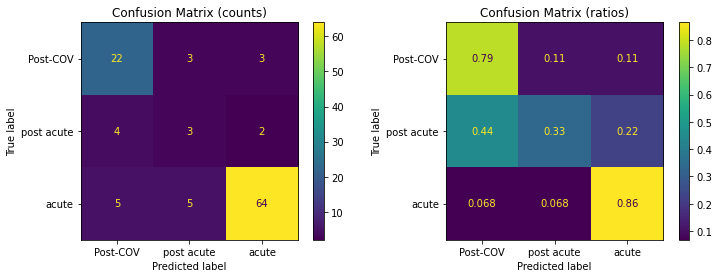

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_pipe.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_pipe.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

## k-NN, no tuning

In [10]:
# The knn baseline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
baseline_knn_score = knn_pipe.score(X_te, y_te)*100
print('Test score', np.round(baseline_knn_score,3))

Test score 81.081


# Grid search with cross-validation: all features

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.model_selection import GridSearchCV

# Logistic regression estimator
logreg_estimator = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(class_weight='balanced'))])

# Grid search with cross-validation
Cs = np.logspace(-3, -1, num=20)

grids = [{"logreg__penalty": ["l2"], "logreg__multi_class": ["ovr"], "logreg__solver": ["liblinear"], "logreg__C": Cs},
   {"logreg__penalty": ["l2"], "logreg__multi_class": ["multinomial"], "logreg__solver": ["saga"],"logreg__C": Cs}]

logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1)

In [12]:
# Fit  estimator
logreg_gscv.fit(X_tr, y_tr)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logreg__C': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.0615848...
                         {'logreg__C': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ]),
                          'logreg__multi_class': ['multinomial'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['saga']}],
             return_train_score=True, verbose=1)

In [13]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "strategy": logreg_gscv.cv_results_["param_logreg__multi_class"],
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,strategy,C,mean_tr,mean_te,std_te
19,ovr,0.1,0.927803,0.825077,0.053316
18,ovr,0.078476,0.922621,0.825077,0.053316
17,ovr,0.061585,0.912674,0.817385,0.052489
16,ovr,0.048329,0.903163,0.809692,0.058623
15,ovr,0.037927,0.893648,0.809692,0.058623


In [14]:
# Print the best estimator
logreg_gscv.best_estimator_.named_steps['logreg']

LogisticRegression(C=0.07847599703514611, class_weight='balanced',
                   multi_class='ovr', solver='liblinear')

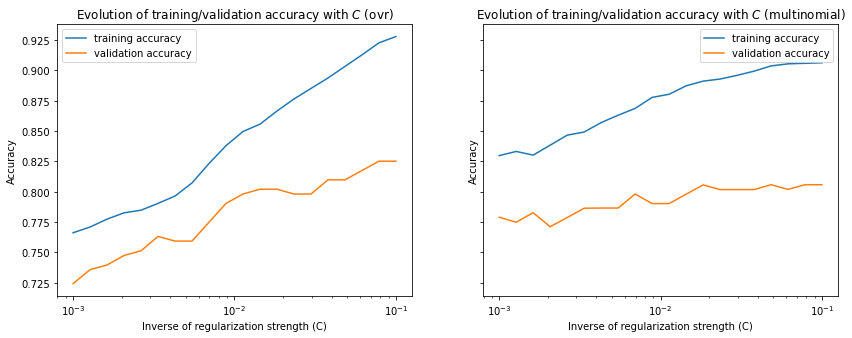

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

logreg_results_ovr=logreg_results[logreg_results['strategy']=='ovr']
logreg_results_multin=logreg_results[logreg_results['strategy']=='multinomial']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot training/validation accuracy curves
ax1.semilogx(logreg_results_ovr["C"], logreg_results_ovr["mean_tr"], label='training accuracy')
ax1.semilogx(logreg_results_ovr["C"], logreg_results_ovr["mean_te"],  label='validation accuracy')

ax1.set_xlabel('Inverse of regularization strength (C)')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="best")
ax1.set_title("Evolution of training/validation accuracy with $C$ (ovr)")

# Plot training/validation accuracy curves
ax2.semilogx(logreg_results_multin["C"], logreg_results_multin["mean_tr"], label='training accuracy')
ax2.semilogx(logreg_results_multin["C"], logreg_results_multin["mean_te"],  label='validation accuracy')

ax2.set_xlabel('Inverse of regularization strength (C)')
ax2.set_ylabel('Accuracy')
ax2.legend(loc="best")
ax2.set_title("Evolution of training/validation accuracy with $C$ (multinomial)")

plt.show()

**Comment:** 
- The one-vs-rest strategy for the multiclass classfication gives better results in terms of the validation accuracy than the multinomial strategy (based on the softmax regression). In the ovr strategy, a binary classfier is fit to separate each class from the other ones.  
- Both models overfit: the difference between the training and the validation accuracy grows with increasing C parameter (so with decreasing regularization strength). Therefore, regularization is needed here to fight the overfitting. Above, the grid search was limited to C parameter < 0.1 to minimize the generalization error with the price of the validation accuracy decrease (the original grid search was done with C in the range (Cs = np.logspace(-3, -3, num=20))).

In [16]:
from sklearn.metrics import classification_report

logreg_gscv.predict(X_te)

test_score_logreg=logreg_gscv.score(X_te, y_te)
%store test_score_logreg
print("Test accuracy: {:.2f}%".format(100 * test_score_logreg))

# Classification report
y_te_preds_logreg = logreg_gscv.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg))

# Extract probabilities
prob_logreg = logreg_gscv.predict_proba(X_te)

Stored 'test_score_logreg' (float64)
Test accuracy: 80.18%
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        28
           1       0.31      0.44      0.36         9
           2       0.94      0.82      0.88        74

    accuracy                           0.80       111
   macro avg       0.66      0.71      0.68       111
weighted avg       0.83      0.80      0.81       111



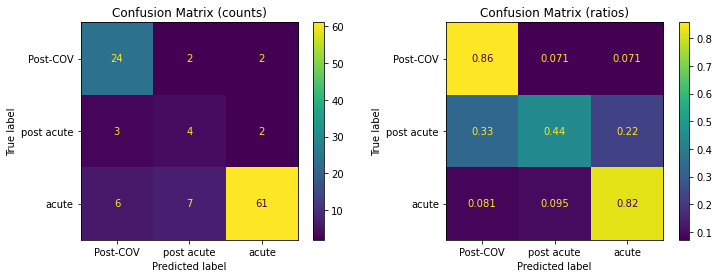

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** 
- The model detects patients in the acute phase of infection 82% of times. Among the 74 patients in the acute phase, 7 were misclassfied as being in the post-acute phase and 6 of them as being completely recovered (post-COVID). If I would like the model to be more sensitive for detecting patients in the acute phase, I may want to increase the recall by decreasing the treshold of probabilities that the classfication is based on. The metabolome/lipidome of the misclassfied patients may be similar to the recovered patients for a number of reasons (good immunity and/or young age etc.) The model precision to detect patients in the acute phase is 94%, meaning that when it predicts acute phase, it is correct 94% of times. 
- The model detects the post-COVID patients 86% of times. The precision of the model to detect these patients is actually lower than the recall. 
- The model misclassfied 5 out of the 9 post acute phase patients. It means that in the 4 correctly classfied patients there is an unique pattern in the qunatities of the metabolites/lipids that makes it possible for them to be distinguished from the patients in the two extreme groups 0 and 2 (post-COVID and the acute phase). The misclassfied ones instead seem to be similar in terms of their metabolome/lipidome to either the recovered patients or the patients in the acute phase. The model predicts 13 post-acute patients overall, but only 4 of them correctly.

# Feature importance based on coefficients

In the following, I will look at the features that have the highest coefficients for each category.

In [18]:
# Access coefficients of the model
coefficients=logreg_gscv.best_estimator_.named_steps['logreg'].coef_
coefficients=pd.DataFrame(coefficients, columns=list(X_tr.columns))
coefficients.shape

(3, 149)

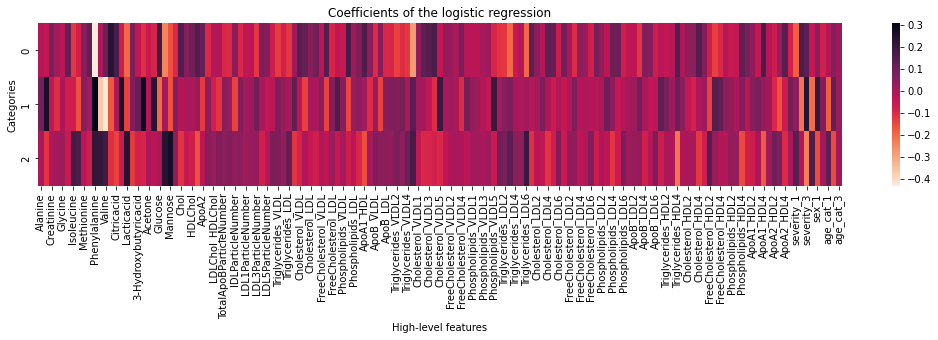

In [19]:
# Plot heatmap with the coefficients of the model
plt.figure(figsize=(18,3))
sns.heatmap(coefficients, cmap = sns.cm.rocket_r)

plt.xlabel('High-level features')
plt.ylabel('Categories')
plt.title("Coefficients of the logistic regression")
plt.show()

In [20]:
logreg_gscv.best_estimator_.classes_

array([0, 1, 2], dtype=int64)

**Comment:** The positive coefficients in each category predict the associated class. 

In [21]:
coefficients['Phenylalanine']

0   -0.431651
1    0.309397
2    0.210615
Name: Phenylalanine, dtype: float64

Here, there is an increase in the probability of being in the post acute phase rather than being post-COVID with the increased quantity of Phenylalanine. It means that Phenylalanine is increased in acute and post acute phase patients. 

In [22]:
coefficients['Acetoaceticacid']

0   -0.107282
1    0.281649
2   -0.085553
Name: Acetoaceticacid, dtype: float64

Here, there is an increase in the probability of being in the post acute phase rather than being post-COVID or in acute phase with the increased quantity of Acetoaceticacid. 

In [23]:
# Sort the coeffcients from the highest to the lowest for each class and store in a DataFrame
feat_highest_coef=[]
for label in range(3):
    feat_highest_coef.append(coefficients.T.iloc[:,label].sort_values(ascending=False).index.tolist())
    
highest_coef=[]
for label in range(3):
    highest_coef.append(list(coefficients.T.iloc[:,label].sort_values(ascending=False)))

In [24]:
# Create df with the names of the top features
feat_highest_coef=pd.DataFrame(feat_highest_coef)
feat_highest_coef.index=['post_COV','post_acute', 'acute']
feat_highest_coef=feat_highest_coef.T
feat_highest_coef.head(15)

,post_COV,post_acute,acute
0,Aceticacid,Phenylalanine,Mannose
1,Glucose,Acetoaceticacid,Glycoproteins
2,Phospholipids_IDL,Creatine,Lacticacid
3,Citricacid,Formicacid,Phenylalanine
4,Cholesterol_VLDL4,Pyruvicacid,Tyrosine
5,ApoA1_HDL4,severity_3,Triglycerides_LDL6
6,severity_2,sex_1,Valine
7,ApoA1_HDL,Phospholipids_VLDL5,Isoleucine
8,ApoA1,Cholesterol_VLDL5,Triglycerides_VLDL5
9,Chol,FreeCholesterol_HDL,Leucine


In [25]:
# Create df with the top coefficients
highest_coef=pd.DataFrame(highest_coef)
highest_coef.index=['post_COV','post_acute', 'acute']
highest_coef=highest_coef.T
highest_coef.head(5)

,post_COV,post_acute,acute
0,0.235794,0.309397,0.270974
1,0.179739,0.281649,0.238893
2,0.169775,0.261498,0.235239
3,0.169645,0.259565,0.210615
4,0.166240,0.238344,0.208000


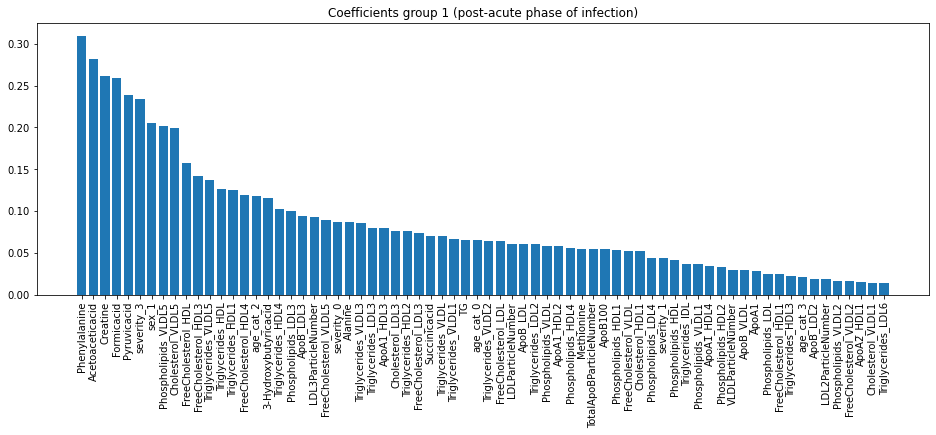

In [26]:
# Plot the coefficients for group 1 (post-acute phase)
post_acute_feat=feat_highest_coef['post_acute']
post_acute_coef=highest_coef['post_acute']

plt.figure(figsize=(16,5))
plt.bar(post_acute_feat[:70], post_acute_coef[:70])
plt.xticks(rotation=90)
plt.title("Coefficients group 1 (post-acute phase of infection)")
plt.show()

# Small metabolites only

In the following, I will reduce the feature space to only 25 features representing the quantities of small metabolites and aminoacids. In order to check h0w much influnce these substances have on the classfication into the three groups independently from the lipids.

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

from sklearn.model_selection import GridSearchCV

# Logistic regression estimator
logreg_estimator = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(class_weight='balanced'))])

# Grid search with cross-validation
Cs = np.logspace(-3, 3, num=20)

grids = [{"logreg__penalty": ["l2"], "logreg__multi_class": ["ovr"], "logreg__solver": ["liblinear"], "logreg__C": Cs}]

logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1)

In [28]:
%store -r metabolite_not_lipid

X_tr_metabolite_not_lipid=X_tr[metabolite_not_lipid]
print('Shape of train data with metabolites features only', X_tr_metabolite_not_lipid.shape)
X_te_metabolite_not_lipid=X_te[metabolite_not_lipid]

X_tr_metabolite_not_lipid.columns

Shape of train data with metabolites features only (257, 25)


Index(['Alanine', 'Creatine', 'Creatinine', 'Glutamine', 'Glycine',
       'Histidine', 'Isoleucine', 'Leucine', 'Methionine', 'Ornithine',
       'Phenylalanine', 'Tyrosine', 'Valine', 'Aceticacid', 'Citricacid',
       'Formicacid', 'Lacticacid', 'Succinicacid', '3-Hydroxybutyricacid',
       'Acetoaceticacid', 'Acetone', 'Pyruvicacid', 'Glucose', 'Glycoproteins',
       'Mannose'],
      dtype='object')

In [29]:
# Fit estimator
logreg_gscv.fit(X_tr_metabolite_not_lipid, y_tr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logreg__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'logreg__multi_class': ['ovr'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['liblinear']}],
             return_train_score=True, verbose=1)

In [30]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,C,mean_tr,mean_te,std_te
11,2.976351,0.914838,0.872000,0.064310
10,1.43845,0.910513,0.864154,0.060044
9,0.695193,0.901433,0.860154,0.062789
12,6.158482,0.922612,0.856308,0.081379
8,0.335982,0.892784,0.856154,0.057338


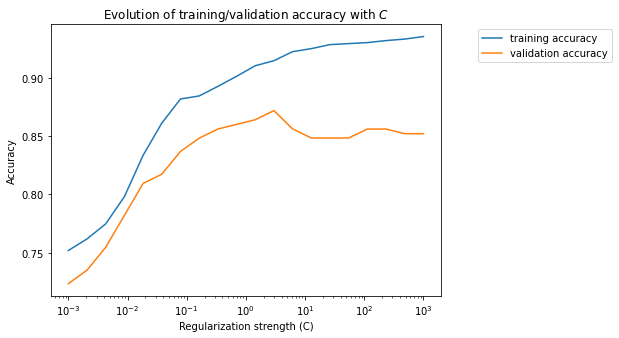

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.semilogx(logreg_results["C"], logreg_results["mean_tr"], label='training accuracy')
plt.semilogx(logreg_results["C"], logreg_results["mean_te"],  label='validation accuracy')

plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
plt.title("Evolution of training/validation accuracy with $C$")
plt.show()

In [32]:
from sklearn.metrics import classification_report

logreg_gscv.predict(X_te_metabolite_not_lipid)

test_score_logreg_metabolite=logreg_gscv.score(X_te_metabolite_not_lipid, y_te)*100
print('Test score', np.round(test_score_logreg_metabolite,3))

# Classification report
y_te_preds_logreg_metabolite = logreg_gscv.predict(X_te_metabolite_not_lipid)
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg_metabolite))

# Extract probabilities
prob_logreg_metabolite = logreg_gscv.predict_proba(X_te_metabolite_not_lipid)

Test score 78.378
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        28
           1       0.40      0.44      0.42         9
           2       0.90      0.84      0.87        74

    accuracy                           0.78       111
   macro avg       0.65      0.68      0.66       111
weighted avg       0.80      0.78      0.79       111



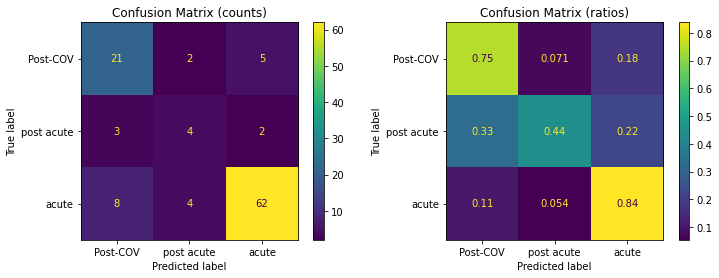

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_metabolite_not_lipid), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_metabolite_not_lipid), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** 
When only small metabolites and aminoacids are used to fit the model, three more post-COVID patients are misclassfied as being in the acute phase of infection. Two more in the acute phase are misclassified as post-COVID and three less as being in the post acute phase. 

# Lipids only

In [34]:
%store -r lipid

X_tr_lipid=X_tr[lipid]
print('Shape of train data with lipid features only', X_tr_lipid.shape)
X_te_lipid=X_te[lipid]

Shape of train data with lipid features only (257, 114)


In [35]:
# Fit estimator
logreg_gscv.fit(X_tr_lipid, y_tr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid=[{'logreg__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'logreg__multi_class': ['ovr'],
                          'logreg__penalty': ['l2'],
                          'logreg__solver': ['liblinear']}],
             return_train_score=True, verbose=1)

In [36]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame(
    {
        "C": logreg_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logreg_gscv.cv_results_["mean_train_score"],
        "mean_te": logreg_gscv.cv_results_["mean_test_score"],
        "std_te": logreg_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
logreg_results.sort_values(by="mean_te", ascending=False).head(5)

,C,mean_tr,mean_te,std_te
9,0.695193,0.915702,0.848769,0.062629
7,0.162378,0.893654,0.844923,0.063841
10,1.43845,0.923052,0.840923,0.065261
8,0.335982,0.906619,0.837077,0.058653
6,0.078476,0.875062,0.833385,0.076401


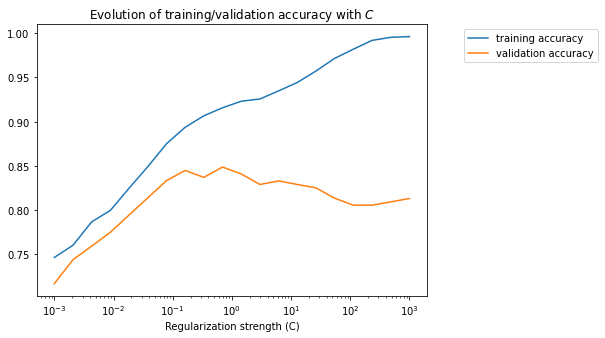

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Plot training/validation accuracy curves
plt.semilogx(logreg_results["C"], logreg_results["mean_tr"], label='training accuracy')
plt.semilogx(logreg_results["C"], logreg_results["mean_te"],  label='validation accuracy')

plt.xlabel('Regularization strength (C)')
plt.legend(bbox_to_anchor=(1.45,1), loc="upper right")
#plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.show()

In [38]:
from sklearn.metrics import classification_report

logreg_gscv.predict(X_te_lipid)

test_score_logreg_lipid=logreg_gscv.score(X_te_lipid, y_te)*100
print('Test score', np.round(test_score_logreg_lipid,3))

# Classification report
y_te_preds_logreg_lipid = logreg_gscv.predict(X_te_lipid)
print(classification_report(y_true=y_te, y_pred=y_te_preds_logreg_lipid))

# Extract probabilities
prob_logreg_lipid = logreg_gscv.predict_proba(X_te_lipid)

Test score 82.883
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.60      0.33      0.43         9
           2       0.88      0.89      0.89        74

    accuracy                           0.83       111
   macro avg       0.74      0.68      0.70       111
weighted avg       0.82      0.83      0.82       111



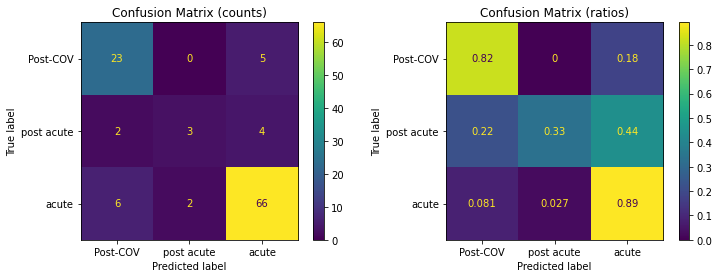

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_lipid), display_labels=['Post-COV','post acute', 'acute'], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_te, logreg_gscv.predict(X_te_lipid), normalize="true", display_labels=['Post-COV','post acute', 'acute'], ax=ax2)

plt.show()

**Comment:** 
When only lipids are used, the overall accuracy of the model increases as does the recall for classfication of teh patients in teh caute pahse of infection. The model predicts only 5 post acute phase patients, three of them correctly. 